## Классификация на датасете MNIST

**Предварительные замечания**: Понятно, что здесь не рассматриваются все возможные модели для классификации, потому что их крайне много. Я сделал несколько моделей типов Linear и CNN с перебором оптимизаторов.

На графиках обучения черные вертикальнеы линии разграничивают эпохи обучения, а красные горизонтальные показывают среднее значение для эпохи (ошибки или точности) 

In [32]:
import torch
from torchvision import datasets
from torch import nn
import numpy as np
from torch import optim
from torchvision.transforms import transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
torch.manual_seed(42)

### Загрузка данных

In [33]:
mnist_train = datasets.MNIST(root="source", train=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root="source", train=False, transform=transforms.ToTensor())

### Метрики модели

In [76]:
def get_accuracy(output, labels):
    pred = output.max(1)[1]
    return accuracy_score(labels, pred)


def get_model_metrics(output, labels):
    pred = output.max(1)[1]
    precision, recall, fscore, _ = precision_recall_fscore_support(labels, pred, average="macro", warn_for=())
    return get_accuracy(output, labels), precision, recall, fscore

### Функции цикла обучения

In [6]:
def train_epoch(model, data, optimiser, loss_func, epoch_num, batch_size):
    # вспомогательные штуки
    tq_iter = tqdm(range(len(data)))
    tq_iter.set_description(f"Epoch {epoch_num} train")
    batch_losses = np.empty((1, 2))
    accuracies = np.empty((1, 2))
    all_output = torch.empty((1, 10))
    all_labels = torch.empty((1))
    iter_data = iter(data)
    # установка training мода
    model.train()
    for ix in tq_iter:
        images, labels = next(iter_data)
        if len(labels) != batch_size:
            continue
        # считаем ошибку и обновляем веса
        optimiser.zero_grad()
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimiser.step()
        # информация для вывода
        batch_losses = np.append(batch_losses, [[ix + len(data) * epoch_num, loss.item()]], axis=0)
        accuracies = np.append(accuracies, [[ix + len(data) * epoch_num, get_accuracy(output, labels)]], axis=0)
        all_output = torch.cat((all_output, output))
        all_labels = torch.cat((all_labels, labels))
        tq_iter.set_postfix({"loss": round(loss.item(), 3)})
    return batch_losses[1:], accuracies[1:], get_accuracy(all_output[1:], all_labels[1:])

In [7]:
def validate_epoch(model, data, loss_func, epoch_num, batch_size):
    # вспомогательные штуки
    tq_iter = tqdm(range(len(data)))
    tq_iter.set_description(f"Epoch {epoch_num} valid")
    iter_data = iter(data)
    batch_losses = np.empty((1, 2))
    accuracies = np.empty((1, 2))
    all_output = torch.empty((1, 10))
    all_labels = torch.empty((1))
    # установка evaluating мода
    model.eval()
    with torch.no_grad():
        for ix in tq_iter:
            images, labels = next(iter_data)
            if len(labels) != batch_size:
                continue
            output = model(images)
            loss = loss_func(output, labels).item()
            # информация для вывода
            batch_losses = np.append(batch_losses, [[ix + len(data) * epoch_num, loss]], axis=0)
            accuracies = np.append(accuracies, [[ix + len(data) * epoch_num, get_accuracy(output, labels)]], axis=0)
            all_output = torch.cat((all_output, output))
            all_labels = torch.cat((all_labels, labels))
            tq_iter.set_postfix({"loss": round(loss, 3)})
    return batch_losses[1:], accuracies[1:], *get_model_metrics(all_output[1:], all_labels[1:])


### Функция для построения графиков

In [8]:
def plot_data_per_epoch(fig, x, y, title="Model", xlabel="BatchNum", ylabel="Loss", log_iters=10, **kwargs):
    fig.set_title(title)
    fig.plot(x[::log_iters], y[::log_iters], **kwargs)
    fig.axvline(x[-1], c="black", linestyle="--")
    fig.hlines(y=np.mean(y), xmin=x[0], xmax=x[-1], colors="red")


### Тест архитектуры

In [43]:
def test_architecture(model, optimiser, loss_func, num_epochs=3, batch_size=64,
                      logging_iters_train=10, logging_iters_valid=3,
                      model_title="Model"):
    
    # загрузхка датасетов
    data_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    data_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
    optimiser = optimiser(model.parameters(), lr=1e-3)

    min_error = 1e9

    _, axs = plt.subplots(2, 2, figsize=(15, 10))
    for i in range(num_epochs):
        # train 
        train_loss, train_accs, train_epoch_acc = train_epoch(
            model, data_train, optimiser, loss_func, i, batch_size
        )
        print("Train Accuracy:", train_epoch_acc)
        # test
        valid_loss, valid_accs, valid_epoch_acc, valid_epoch_prec, valid_epoch_rec, valid_epoch_fscore = validate_epoch(
            model, data_test, loss_func, i, batch_size
        )
        min_error_epoch = valid_loss[:, 1].min()
        min_error = min(min_error, min_error_epoch)
        print("Valid Accuracy:", valid_epoch_acc)

        # графики обучения
        plot_data_per_epoch(axs[0, 0], train_loss[:, 0], train_loss[:, 1], 
                            title=f"{model_title} train losses", log_iters=logging_iters_train)
        plot_data_per_epoch(axs[0, 1], train_accs[:, 0], train_accs[:, 1],
                            title=f"{model_title} train accuracy", log_iters=logging_iters_train)
        plot_data_per_epoch(axs[1, 0], valid_loss[:, 0], valid_loss[:, 1],
                            title=f"{model_title} valid losses", log_iters=logging_iters_valid)
        plot_data_per_epoch(axs[1, 1], valid_accs[:, 0], valid_accs[:, 1],
                            title=f"{model_title} valid accuracy", log_iters=logging_iters_valid)
    
    return (model_title, optimiser.__class__.__name__, loss_func.__class__.__name__, min_error,
        valid_epoch_acc, valid_epoch_prec, valid_epoch_rec, valid_epoch_fscore)
    

### Линейные модели

#### Linear (no hidden layers) + SGD + CrossEnropy

In [35]:
class LinearNoHidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28 * 28, 10)
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        return self.linear(x)

Epoch 0 train: 100%|██████████| 938/938 [00:06<00:00, 145.37it/s, loss=1.57]


Train Accuracy: 0.5682697438633938


Epoch 0 valid: 100%|██████████| 157/157 [00:00<00:00, 180.62it/s, loss=1.69]


Valid Accuracy: 0.7443910256410257


Epoch 1 train: 100%|██████████| 938/938 [00:06<00:00, 136.14it/s, loss=1.15]


Train Accuracy: 0.7690101387406617


Epoch 1 valid: 100%|██████████| 157/157 [00:00<00:00, 171.46it/s, loss=1.36] 


Valid Accuracy: 0.7986778846153846


Epoch 2 train: 100%|██████████| 938/938 [00:24<00:00, 38.30it/s, loss=1.07]  


Train Accuracy: 0.8012606723585912


Epoch 2 valid: 100%|██████████| 157/157 [00:04<00:00, 34.97it/s, loss=1.18] 


Valid Accuracy: 0.8204126602564102


Epoch 3 train: 100%|██████████| 938/938 [00:44<00:00, 21.23it/s, loss=0.834]


Train Accuracy: 0.8176527481323372


Epoch 3 valid: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s, loss=1.07] 


Valid Accuracy: 0.8331330128205128


Epoch 4 train: 100%|██████████| 938/938 [00:06<00:00, 147.48it/s, loss=0.772]


Train Accuracy: 0.829175560298826


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 170.33it/s, loss=0.999]


Valid Accuracy: 0.83984375


Epoch 5 train: 100%|██████████| 938/938 [00:06<00:00, 134.64it/s, loss=0.864]


Train Accuracy: 0.8364294290288153


Epoch 5 valid: 100%|██████████| 157/157 [00:01<00:00, 154.45it/s, loss=0.947]


Valid Accuracy: 0.8474559294871795


Epoch 6 train: 100%|██████████| 938/938 [00:06<00:00, 143.16it/s, loss=0.663]


Train Accuracy: 0.8429328975453575


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 147.04it/s, loss=0.906]


Valid Accuracy: 0.8524639423076923


Epoch 7 train: 100%|██████████| 938/938 [00:06<00:00, 139.51it/s, loss=0.653]


Train Accuracy: 0.8480356189967982


Epoch 7 valid: 100%|██████████| 157/157 [00:01<00:00, 149.72it/s, loss=0.874]


Valid Accuracy: 0.8592748397435898


Epoch 8 train: 100%|██████████| 938/938 [00:06<00:00, 134.86it/s, loss=0.591]


Train Accuracy: 0.8521044557097118


Epoch 8 valid: 100%|██████████| 157/157 [00:00<00:00, 166.70it/s, loss=0.849]


Valid Accuracy: 0.862479967948718


Epoch 9 train: 100%|██████████| 938/938 [00:06<00:00, 137.34it/s, loss=0.598]


Train Accuracy: 0.8553728655282817


Epoch 9 valid: 100%|██████████| 157/157 [00:00<00:00, 176.00it/s, loss=0.827]


Valid Accuracy: 0.8667868589743589


Epoch 10 train: 100%|██████████| 938/938 [00:06<00:00, 136.19it/s, loss=0.511]


Train Accuracy: 0.8580242796157951


Epoch 10 valid: 100%|██████████| 157/157 [00:00<00:00, 177.70it/s, loss=0.808]


Valid Accuracy: 0.8689903846153846


Epoch 11 train: 100%|██████████| 938/938 [00:07<00:00, 131.37it/s, loss=0.721]


Train Accuracy: 0.8606256670224119


Epoch 11 valid: 100%|██████████| 157/157 [00:00<00:00, 169.54it/s, loss=0.793]


Valid Accuracy: 0.8706931089743589


Epoch 12 train: 100%|██████████| 938/938 [00:06<00:00, 140.13it/s, loss=0.614]


Train Accuracy: 0.8629102187833512


Epoch 12 valid: 100%|██████████| 157/157 [00:00<00:00, 180.33it/s, loss=0.78] 


Valid Accuracy: 0.8730969551282052


Epoch 13 train: 100%|██████████| 938/938 [00:06<00:00, 146.75it/s, loss=0.741]


Train Accuracy: 0.8649779882604055


Epoch 13 valid: 100%|██████████| 157/157 [00:00<00:00, 163.24it/s, loss=0.768]


Valid Accuracy: 0.875


Epoch 14 train: 100%|██████████| 938/938 [00:06<00:00, 140.50it/s, loss=0.521]


Train Accuracy: 0.8665955176093917


Epoch 14 valid: 100%|██████████| 157/157 [00:00<00:00, 171.00it/s, loss=0.757]


Valid Accuracy: 0.8761017628205128


Epoch 15 train: 100%|██████████| 938/938 [00:06<00:00, 139.54it/s, loss=0.377]


Train Accuracy: 0.8684631803628602


Epoch 15 valid: 100%|██████████| 157/157 [00:00<00:00, 166.12it/s, loss=0.747]


Valid Accuracy: 0.878104967948718


Epoch 16 train: 100%|██████████| 938/938 [00:06<00:00, 136.36it/s, loss=0.679]


Train Accuracy: 0.8700640341515475


Epoch 16 valid: 100%|██████████| 157/157 [00:01<00:00, 150.99it/s, loss=0.739]


Valid Accuracy: 0.87890625


Epoch 17 train: 100%|██████████| 938/938 [00:06<00:00, 138.42it/s, loss=0.532]


Train Accuracy: 0.8712479989327642


Epoch 17 valid: 100%|██████████| 157/157 [00:00<00:00, 164.95it/s, loss=0.731]


Valid Accuracy: 0.8809094551282052


Epoch 18 train: 100%|██████████| 938/938 [00:06<00:00, 139.00it/s, loss=0.468]


Train Accuracy: 0.8727154482390609


Epoch 18 valid: 100%|██████████| 157/157 [00:00<00:00, 159.40it/s, loss=0.724]


Valid Accuracy: 0.8819110576923077


Epoch 19 train: 100%|██████████| 938/938 [00:06<00:00, 137.94it/s, loss=0.39] 


Train Accuracy: 0.8738327107790822


Epoch 19 valid: 100%|██████████| 157/157 [00:00<00:00, 158.82it/s, loss=0.717]


Valid Accuracy: 0.8829126602564102


Epoch 20 train: 100%|██████████| 938/938 [00:06<00:00, 139.97it/s, loss=0.537]


Train Accuracy: 0.8748165688367129


Epoch 20 valid: 100%|██████████| 157/157 [00:00<00:00, 180.45it/s, loss=0.711]


Valid Accuracy: 0.8830128205128205


Epoch 21 train: 100%|██████████| 938/938 [00:06<00:00, 141.27it/s, loss=0.614]


Train Accuracy: 0.8761172625400213


Epoch 21 valid: 100%|██████████| 157/157 [00:00<00:00, 160.47it/s, loss=0.705]


Valid Accuracy: 0.8840144230769231


Epoch 22 train: 100%|██████████| 938/938 [00:06<00:00, 142.42it/s, loss=0.474]


Train Accuracy: 0.8770010672358591


Epoch 22 valid: 100%|██████████| 157/157 [00:00<00:00, 167.03it/s, loss=0.7]  


Valid Accuracy: 0.8847155448717948


Epoch 23 train: 100%|██████████| 938/938 [00:06<00:00, 140.00it/s, loss=0.402]


Train Accuracy: 0.8778348452508005


Epoch 23 valid: 100%|██████████| 157/157 [00:00<00:00, 163.45it/s, loss=0.695]


Valid Accuracy: 0.8868189102564102


Epoch 24 train: 100%|██████████| 938/938 [00:06<00:00, 141.05it/s, loss=0.572]


Train Accuracy: 0.8786686232657417


Epoch 24 valid: 100%|██████████| 157/157 [00:00<00:00, 162.57it/s, loss=0.69] 


Valid Accuracy: 0.8872195512820513


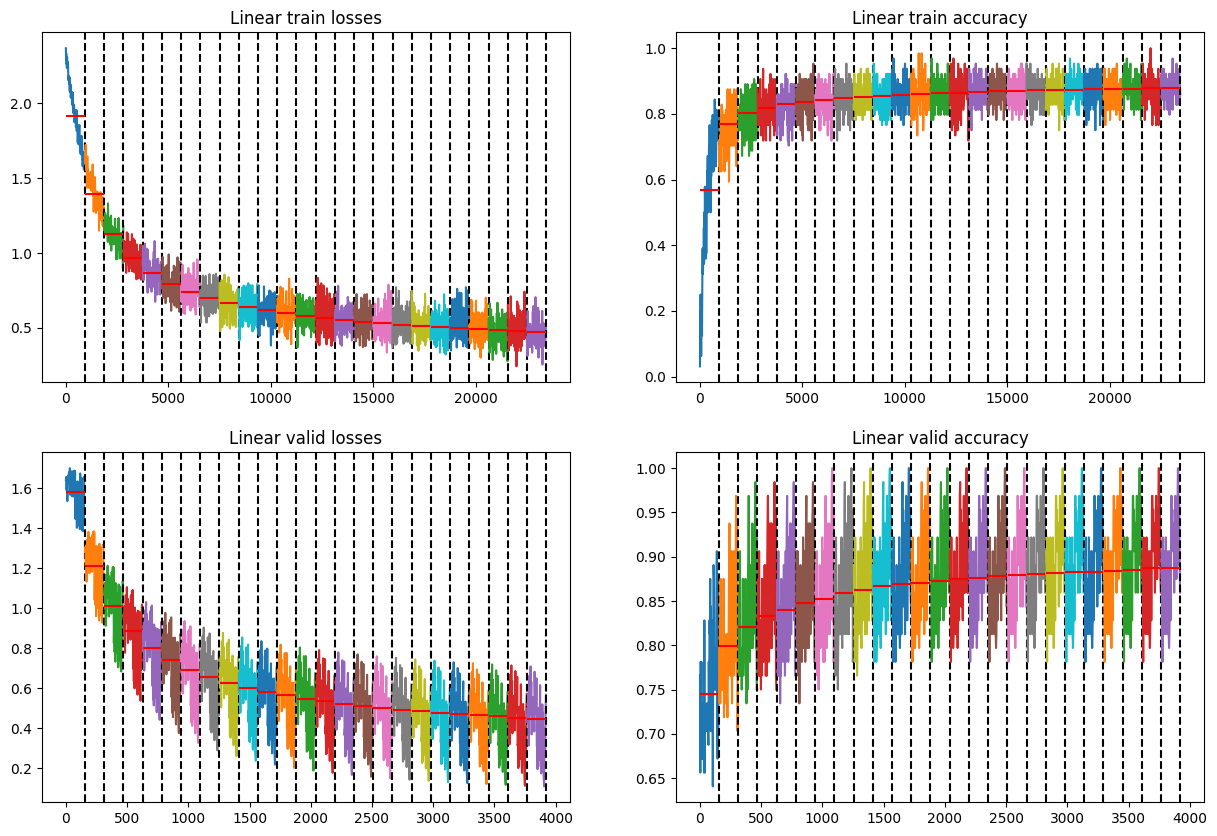

In [54]:
lin1 = test_architecture(LinearNoHidden(), optim.SGD, nn.CrossEntropyLoss(), num_epochs=25,
                         model_title="Linear")

**ВЫВОД**: Модель вроде сходится, но очень и очень долго. НА последних эпохах accuracy колеблется, вероятно, дальше результат улучшаться не будет (а, может, и станет ухудшаться из-за переобучения, с которым я в этой модели никак не работаю). Точность имеет большой размах в рамках эпохи

#### Linear (no hidden layers) + Adam + CrossEntropyLoss

Epoch 0 train: 100%|██████████| 938/938 [00:06<00:00, 136.75it/s, loss=0.41] 


Train Accuracy: 0.8707477321237994


Epoch 0 valid: 100%|██████████| 157/157 [00:00<00:00, 163.51it/s, loss=0.561]


Valid Accuracy: 0.9103565705128205


Epoch 1 train: 100%|██████████| 938/938 [00:07<00:00, 132.84it/s, loss=0.46] 


Train Accuracy: 0.9105856456776947


Epoch 1 valid: 100%|██████████| 157/157 [00:00<00:00, 190.43it/s, loss=0.503]


Valid Accuracy: 0.9182692307692307


Epoch 2 train: 100%|██████████| 938/938 [00:07<00:00, 133.60it/s, loss=0.225]


Train Accuracy: 0.9176894343649946


Epoch 2 valid: 100%|██████████| 157/157 [00:00<00:00, 165.89it/s, loss=0.466]


Valid Accuracy: 0.921073717948718


Epoch 3 train: 100%|██████████| 938/938 [00:07<00:00, 132.08it/s, loss=0.148]


Train Accuracy: 0.9208911419423693


Epoch 3 valid: 100%|██████████| 157/157 [00:00<00:00, 163.36it/s, loss=0.441]


Valid Accuracy: 0.9238782051282052


Epoch 4 train: 100%|██████████| 938/938 [00:06<00:00, 137.53it/s, loss=0.451]


Train Accuracy: 0.9231923692636073


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 168.94it/s, loss=0.449]


Valid Accuracy: 0.9232772435897436


Epoch 5 train: 100%|██████████| 938/938 [00:07<00:00, 132.83it/s, loss=0.445]


Train Accuracy: 0.9254935965848452


Epoch 5 valid: 100%|██████████| 157/157 [00:00<00:00, 166.12it/s, loss=0.43] 


Valid Accuracy: 0.9238782051282052


Epoch 6 train: 100%|██████████| 938/938 [00:06<00:00, 135.52it/s, loss=0.239]


Train Accuracy: 0.9267275880469584


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 155.20it/s, loss=0.423]


Valid Accuracy: 0.9254807692307693


Epoch 7 train: 100%|██████████| 938/938 [00:07<00:00, 129.74it/s, loss=0.528]


Train Accuracy: 0.9276780949839915


Epoch 7 valid: 100%|██████████| 157/157 [00:00<00:00, 170.65it/s, loss=0.444]


Valid Accuracy: 0.9277844551282052


Epoch 8 train: 100%|██████████| 938/938 [00:06<00:00, 134.77it/s, loss=0.272]


Train Accuracy: 0.9287620064034151


Epoch 8 valid: 100%|██████████| 157/157 [00:01<00:00, 150.73it/s, loss=0.42] 


Valid Accuracy: 0.9276842948717948


Epoch 9 train: 100%|██████████| 938/938 [00:07<00:00, 128.69it/s, loss=0.156]


Train Accuracy: 0.9298459178228389


Epoch 9 valid: 100%|██████████| 157/157 [00:00<00:00, 169.88it/s, loss=0.412]


Valid Accuracy: 0.9258814102564102


Epoch 10 train: 100%|██████████| 938/938 [00:07<00:00, 129.56it/s, loss=0.378]


Train Accuracy: 0.929929295624333


Epoch 10 valid: 100%|██████████| 157/157 [00:00<00:00, 179.24it/s, loss=0.418]


Valid Accuracy: 0.9269831730769231


Epoch 11 train: 100%|██████████| 938/938 [00:06<00:00, 136.57it/s, loss=0.132]


Train Accuracy: 0.9306463447171825


Epoch 11 valid: 100%|██████████| 157/157 [00:00<00:00, 159.47it/s, loss=0.429]


Valid Accuracy: 0.9266826923076923


Epoch 12 train: 100%|██████████| 938/938 [00:07<00:00, 129.60it/s, loss=0.147]


Train Accuracy: 0.9312633404482391


Epoch 12 valid: 100%|██████████| 157/157 [00:00<00:00, 165.52it/s, loss=0.418]


Valid Accuracy: 0.9260817307692307


Epoch 13 train: 100%|██████████| 938/938 [00:06<00:00, 134.42it/s, loss=0.177]


Train Accuracy: 0.9310298826040555


Epoch 13 valid: 100%|██████████| 157/157 [00:00<00:00, 159.95it/s, loss=0.427]


Valid Accuracy: 0.9273838141025641


Epoch 14 train: 100%|██████████| 938/938 [00:07<00:00, 126.36it/s, loss=0.286]


Train Accuracy: 0.9316635538954109


Epoch 14 valid: 100%|██████████| 157/157 [00:00<00:00, 160.15it/s, loss=0.406]


Valid Accuracy: 0.9261818910256411


Epoch 15 train: 100%|██████████| 938/938 [00:07<00:00, 127.24it/s, loss=0.104]


Train Accuracy: 0.9317802828175027


Epoch 15 valid: 100%|██████████| 157/157 [00:00<00:00, 171.38it/s, loss=0.385]


Valid Accuracy: 0.9273838141025641


Epoch 16 train: 100%|██████████| 938/938 [00:07<00:00, 131.06it/s, loss=0.261]


Train Accuracy: 0.932230522945571


Epoch 16 valid: 100%|██████████| 157/157 [00:00<00:00, 159.64it/s, loss=0.419]


Valid Accuracy: 0.9271834935897436


Epoch 17 train: 100%|██████████| 938/938 [00:07<00:00, 133.48it/s, loss=0.364]


Train Accuracy: 0.933564567769477


Epoch 17 valid: 100%|██████████| 157/157 [00:00<00:00, 177.17it/s, loss=0.408]


Valid Accuracy: 0.9275841346153846


Epoch 18 train: 100%|██████████| 938/938 [00:07<00:00, 133.28it/s, loss=0.168]


Train Accuracy: 0.9334645144076841


Epoch 18 valid: 100%|██████████| 157/157 [00:00<00:00, 167.03it/s, loss=0.435]


Valid Accuracy: 0.9285857371794872


Epoch 19 train: 100%|██████████| 938/938 [00:07<00:00, 133.74it/s, loss=0.213]


Train Accuracy: 0.9336145944503735


Epoch 19 valid: 100%|██████████| 157/157 [00:00<00:00, 165.41it/s, loss=0.415]


Valid Accuracy: 0.9269831730769231


Epoch 20 train: 100%|██████████| 938/938 [00:07<00:00, 128.29it/s, loss=0.226]


Train Accuracy: 0.9333311099252934


Epoch 20 valid: 100%|██████████| 157/157 [00:01<00:00, 155.25it/s, loss=0.398]


Valid Accuracy: 0.9263822115384616


Epoch 21 train: 100%|██████████| 938/938 [00:07<00:00, 127.26it/s, loss=0.398]


Train Accuracy: 0.9335478922091782


Epoch 21 valid: 100%|██████████| 157/157 [00:00<00:00, 160.59it/s, loss=0.409]


Valid Accuracy: 0.9274839743589743


Epoch 22 train: 100%|██████████| 938/938 [00:07<00:00, 127.00it/s, loss=0.232]


Train Accuracy: 0.934048159018143


Epoch 22 valid: 100%|██████████| 157/157 [00:01<00:00, 146.92it/s, loss=0.421]


Valid Accuracy: 0.9272836538461539


Epoch 23 train: 100%|██████████| 938/938 [00:07<00:00, 124.82it/s, loss=0.285]


Train Accuracy: 0.9340981856990395


Epoch 23 valid: 100%|██████████| 157/157 [00:00<00:00, 168.55it/s, loss=0.408]


Valid Accuracy: 0.9269831730769231


Epoch 24 train: 100%|██████████| 938/938 [00:07<00:00, 131.34it/s, loss=0.442]


Train Accuracy: 0.9346651547491995


Epoch 24 valid: 100%|██████████| 157/157 [00:00<00:00, 162.56it/s, loss=0.413]


Valid Accuracy: 0.9263822115384616


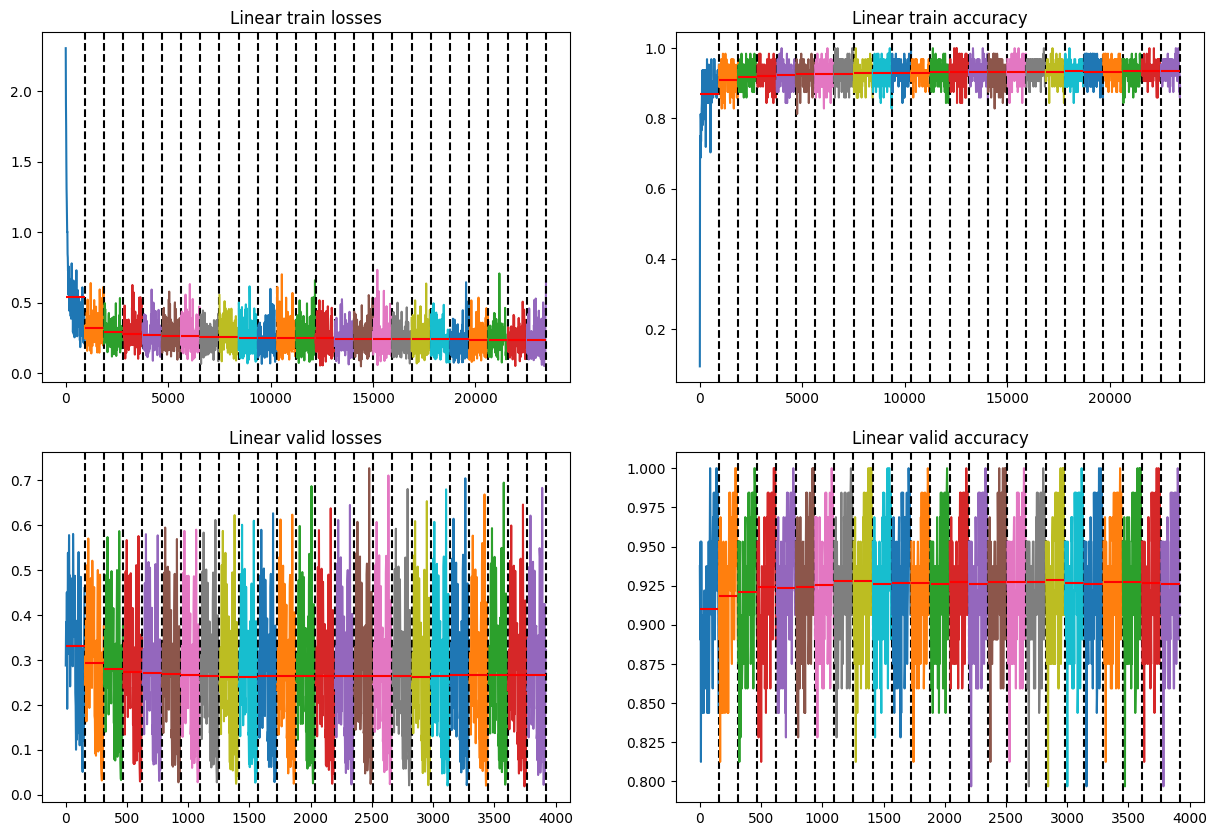

In [56]:
lin2 = test_architecture(LinearNoHidden(), optim.Adam, nn.CrossEntropyLoss(), num_epochs=25,
                         model_title="Linear")

**ВЫВОД**: модель гораздо быстрее пришла к своему плато, к тому же, точность стала немного выше, но, как можно заметить, н последних эпохах ошибка то увеличивается, то уменьшается, то же самое относительно точности. Наверное, тут модель уже начинает переобучаться

#### Linear (no hidden layers) + AdamW + CrossEntropyLoss

Epoch 0 train: 100%|██████████| 938/938 [00:06<00:00, 154.43it/s, loss=0.293]


Train Accuracy: 0.8671624866595518


Epoch 0 valid: 100%|██████████| 157/157 [00:00<00:00, 168.13it/s, loss=0.538]


Valid Accuracy: 0.9127604166666666


Epoch 1 train: 100%|██████████| 938/938 [00:06<00:00, 153.77it/s, loss=0.258]


Train Accuracy: 0.910468916755603


Epoch 1 valid: 100%|██████████| 157/157 [00:00<00:00, 191.37it/s, loss=0.474]


Valid Accuracy: 0.91796875


Epoch 2 train: 100%|██████████| 938/938 [00:06<00:00, 154.60it/s, loss=0.24] 


Train Accuracy: 0.9171891675560299


Epoch 2 valid: 100%|██████████| 157/157 [00:00<00:00, 168.28it/s, loss=0.434]


Valid Accuracy: 0.9204727564102564


Epoch 3 train: 100%|██████████| 938/938 [00:06<00:00, 152.93it/s, loss=0.284]


Train Accuracy: 0.9211412753468516


Epoch 3 valid: 100%|██████████| 157/157 [00:00<00:00, 176.73it/s, loss=0.434]


Valid Accuracy: 0.9223758012820513


Epoch 4 train: 100%|██████████| 938/938 [00:06<00:00, 151.30it/s, loss=0.227]


Train Accuracy: 0.9234258271077909


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 187.29it/s, loss=0.435]


Valid Accuracy: 0.9253806089743589


Epoch 5 train: 100%|██████████| 938/938 [00:06<00:00, 150.10it/s, loss=0.171]


Train Accuracy: 0.924559765208111


Epoch 5 valid: 100%|██████████| 157/157 [00:00<00:00, 186.96it/s, loss=0.427]


Valid Accuracy: 0.9243790064102564


Epoch 6 train: 100%|██████████| 938/938 [00:06<00:00, 153.03it/s, loss=0.457]


Train Accuracy: 0.9260772411953042


Epoch 6 valid: 100%|██████████| 157/157 [00:00<00:00, 160.22it/s, loss=0.418]


Valid Accuracy: 0.9261818910256411


Epoch 7 train: 100%|██████████| 938/938 [00:21<00:00, 42.83it/s, loss=0.234]


Train Accuracy: 0.9274112860192102


Epoch 7 valid: 100%|██████████| 157/157 [00:03<00:00, 45.84it/s, loss=0.421]


Valid Accuracy: 0.9260817307692307


Epoch 8 train: 100%|██████████| 938/938 [00:39<00:00, 23.61it/s, loss=0.248]


Train Accuracy: 0.9283617929562433


Epoch 8 valid: 100%|██████████| 157/157 [00:04<00:00, 31.43it/s, loss=0.424]


Valid Accuracy: 0.9272836538461539


Epoch 9 train: 100%|██████████| 938/938 [00:28<00:00, 32.96it/s, loss=0.253] 


Train Accuracy: 0.9293456510138741


Epoch 9 valid: 100%|██████████| 157/157 [00:00<00:00, 184.96it/s, loss=0.422]


Valid Accuracy: 0.9268830128205128


Epoch 10 train: 100%|██████████| 938/938 [00:06<00:00, 148.13it/s, loss=0.263]


Train Accuracy: 0.9300126734258272


Epoch 10 valid: 100%|██████████| 157/157 [00:00<00:00, 182.51it/s, loss=0.425]


Valid Accuracy: 0.9269831730769231


Epoch 11 train: 100%|██████████| 938/938 [00:06<00:00, 150.58it/s, loss=0.247]


Train Accuracy: 0.9291788954108858


Epoch 11 valid: 100%|██████████| 157/157 [00:04<00:00, 32.90it/s, loss=0.414]


Valid Accuracy: 0.9286858974358975


Epoch 12 train: 100%|██████████| 938/938 [00:48<00:00, 19.50it/s, loss=0.306]


Train Accuracy: 0.9305629669156884


Epoch 12 valid: 100%|██████████| 157/157 [00:04<00:00, 33.50it/s, loss=0.41] 


Valid Accuracy: 0.9274839743589743


Epoch 13 train: 100%|██████████| 938/938 [00:06<00:00, 149.99it/s, loss=0.194]


Train Accuracy: 0.9305796424759872


Epoch 13 valid: 100%|██████████| 157/157 [00:00<00:00, 189.24it/s, loss=0.424]


Valid Accuracy: 0.924979967948718


Epoch 14 train: 100%|██████████| 938/938 [00:06<00:00, 147.95it/s, loss=0.153]


Train Accuracy: 0.9312633404482391


Epoch 14 valid: 100%|██████████| 157/157 [00:00<00:00, 180.25it/s, loss=0.413]


Valid Accuracy: 0.9283854166666666


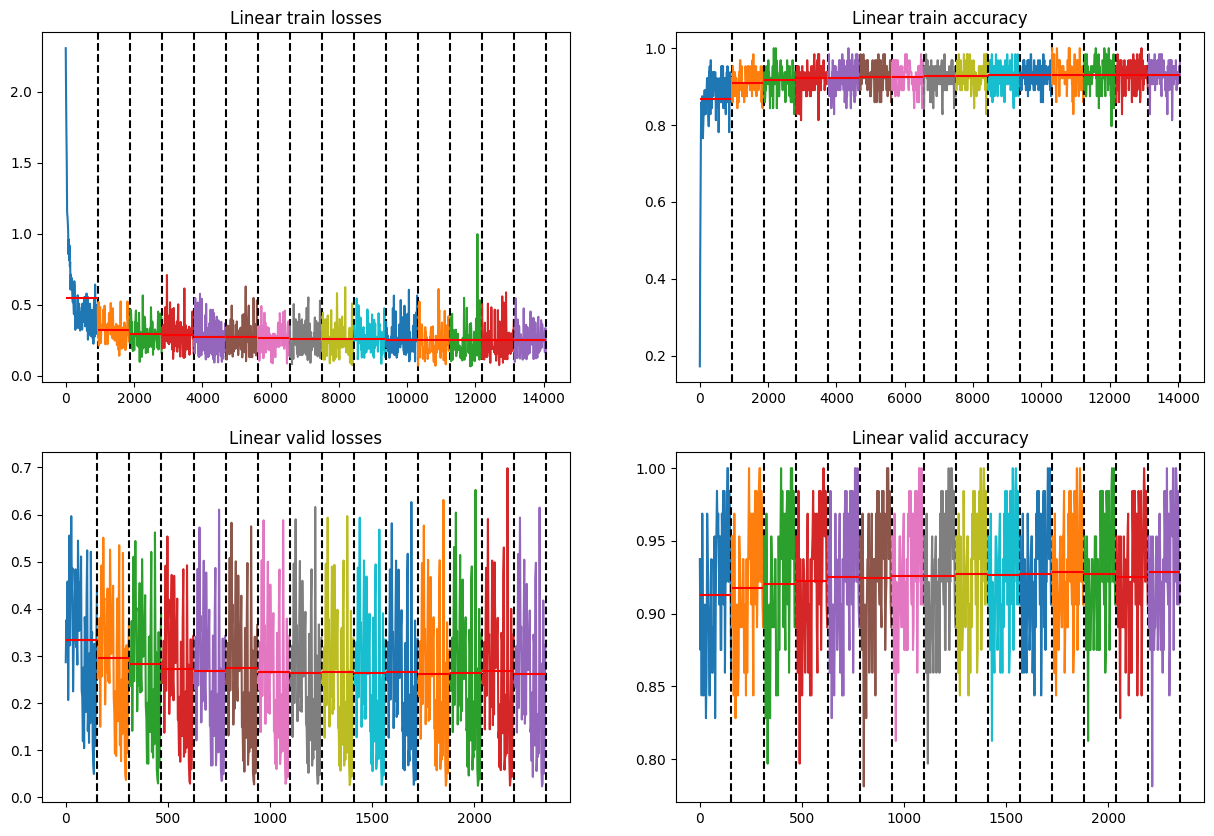

In [52]:
lin3 = test_architecture(LinearNoHidden(), optim.AdamW, nn.CrossEntropyLoss(), num_epochs=20,
                         model_title="Linear")

**ВЫВОД**: очень похоже на предыдущую модель, разве что размах ошибки и точности чуть больше

#### Linear + RELU (1 hidden layer) + SGD + CrossEntropyLoss

In [59]:
class Linear1RELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28 * 28, 200)
        self.linear2 = nn.Linear(200, 50)
        self.linear3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x


Epoch 0 train: 100%|██████████| 938/938 [00:07<00:00, 121.96it/s, loss=2.28]


Train Accuracy: 0.1230156083244397


Epoch 0 valid: 100%|██████████| 157/157 [00:01<00:00, 152.00it/s, loss=2.27]
d:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Accuracy: 0.21654647435897437


Epoch 1 train: 100%|██████████| 938/938 [00:07<00:00, 124.96it/s, loss=2.24]


Train Accuracy: 0.3152514674493063


Epoch 1 valid: 100%|██████████| 157/157 [00:01<00:00, 144.05it/s, loss=2.24]
d:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Accuracy: 0.42658253205128205


Epoch 2 train: 100%|██████████| 938/938 [00:07<00:00, 119.50it/s, loss=2.18]


Train Accuracy: 0.49131203308431165


Epoch 2 valid: 100%|██████████| 157/157 [00:00<00:00, 158.32it/s, loss=2.19]
d:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Accuracy: 0.535957532051282


Epoch 3 train: 100%|██████████| 938/938 [00:07<00:00, 120.31it/s, loss=2.08]


Train Accuracy: 0.5472251867662753


Epoch 3 valid: 100%|██████████| 157/157 [00:01<00:00, 154.66it/s, loss=2.09]
d:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Accuracy: 0.5821314102564102


Epoch 4 train: 100%|██████████| 938/938 [00:07<00:00, 120.10it/s, loss=1.95]


Train Accuracy: 0.5926827641408752


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 162.66it/s, loss=1.94]
d:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Accuracy: 0.6198918269230769


Epoch 5 train: 100%|██████████| 938/938 [00:07<00:00, 122.58it/s, loss=1.65]


Train Accuracy: 0.6333044290288153


Epoch 5 valid: 100%|██████████| 157/157 [00:01<00:00, 152.51it/s, loss=1.73]


Valid Accuracy: 0.6664663461538461


Epoch 6 train: 100%|██████████| 938/938 [00:07<00:00, 122.48it/s, loss=1.46]


Train Accuracy: 0.6798459178228389


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 147.55it/s, loss=1.46]


Valid Accuracy: 0.7110376602564102


Epoch 7 train: 100%|██████████| 938/938 [00:07<00:00, 120.72it/s, loss=1.11] 


Train Accuracy: 0.7263040288153682


Epoch 7 valid: 100%|██████████| 157/157 [00:01<00:00, 147.37it/s, loss=1.21] 


Valid Accuracy: 0.7595152243589743


Epoch 8 train: 100%|██████████| 938/938 [00:07<00:00, 117.84it/s, loss=1.02] 


Train Accuracy: 0.7703608591248666


Epoch 8 valid: 100%|██████████| 157/157 [00:01<00:00, 155.93it/s, loss=1.02] 


Valid Accuracy: 0.7946714743589743


Epoch 9 train: 100%|██████████| 938/938 [00:11<00:00, 83.65it/s, loss=0.824]


Train Accuracy: 0.797925560298826


Epoch 9 valid: 100%|██████████| 157/157 [00:01<00:00, 109.76it/s, loss=0.907]


Valid Accuracy: 0.815604967948718


Epoch 10 train: 100%|██████████| 938/938 [00:11<00:00, 81.28it/s, loss=0.748]


Train Accuracy: 0.8176027214514408


Epoch 10 valid: 100%|██████████| 157/157 [00:01<00:00, 104.75it/s, loss=0.831]


Valid Accuracy: 0.8298277243589743


Epoch 11 train: 100%|██████████| 938/938 [00:11<00:00, 79.01it/s, loss=0.726]


Train Accuracy: 0.8298259071504802


Epoch 11 valid: 100%|██████████| 157/157 [00:01<00:00, 98.10it/s, loss=0.78] 


Valid Accuracy: 0.8382411858974359


Epoch 12 train: 100%|██████████| 938/938 [00:11<00:00, 82.76it/s, loss=0.694]


Train Accuracy: 0.8390975186766275


Epoch 12 valid: 100%|██████████| 157/157 [00:01<00:00, 108.36it/s, loss=0.741]


Valid Accuracy: 0.8486578525641025


Epoch 13 train: 100%|██████████| 938/938 [00:09<00:00, 102.12it/s, loss=0.441]


Train Accuracy: 0.8474186232657417


Epoch 13 valid: 100%|██████████| 157/157 [00:01<00:00, 144.77it/s, loss=0.717]


Valid Accuracy: 0.8550681089743589


Epoch 14 train: 100%|██████████| 938/938 [00:07<00:00, 117.31it/s, loss=0.424]


Train Accuracy: 0.8550893810032018


Epoch 14 valid: 100%|██████████| 157/157 [00:01<00:00, 149.50it/s, loss=0.697]


Valid Accuracy: 0.8618790064102564


Epoch 15 train: 100%|██████████| 938/938 [00:07<00:00, 118.48it/s, loss=0.589]


Train Accuracy: 0.8609591782283885


Epoch 15 valid: 100%|██████████| 157/157 [00:00<00:00, 157.02it/s, loss=0.681]


Valid Accuracy: 0.8669871794871795


Epoch 16 train: 100%|██████████| 938/938 [00:07<00:00, 119.07it/s, loss=0.563]


Train Accuracy: 0.8653782017075774


Epoch 16 valid: 100%|██████████| 157/157 [00:00<00:00, 162.53it/s, loss=0.668]


Valid Accuracy: 0.8726963141025641


Epoch 17 train: 100%|██████████| 938/938 [00:07<00:00, 117.53it/s, loss=0.524]


Train Accuracy: 0.8696137940234792


Epoch 17 valid: 100%|██████████| 157/157 [00:01<00:00, 152.84it/s, loss=0.659]


Valid Accuracy: 0.8774038461538461


Epoch 18 train: 100%|██████████| 938/938 [00:54<00:00, 17.18it/s, loss=0.417]


Train Accuracy: 0.8736159284951974


Epoch 18 valid: 100%|██████████| 157/157 [00:08<00:00, 18.15it/s, loss=0.651]


Valid Accuracy: 0.8801081730769231


Epoch 19 train: 100%|██████████| 938/938 [00:40<00:00, 23.24it/s, loss=0.425]


Train Accuracy: 0.8773012273212379


Epoch 19 valid: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s, loss=0.644]


Valid Accuracy: 0.8823116987179487


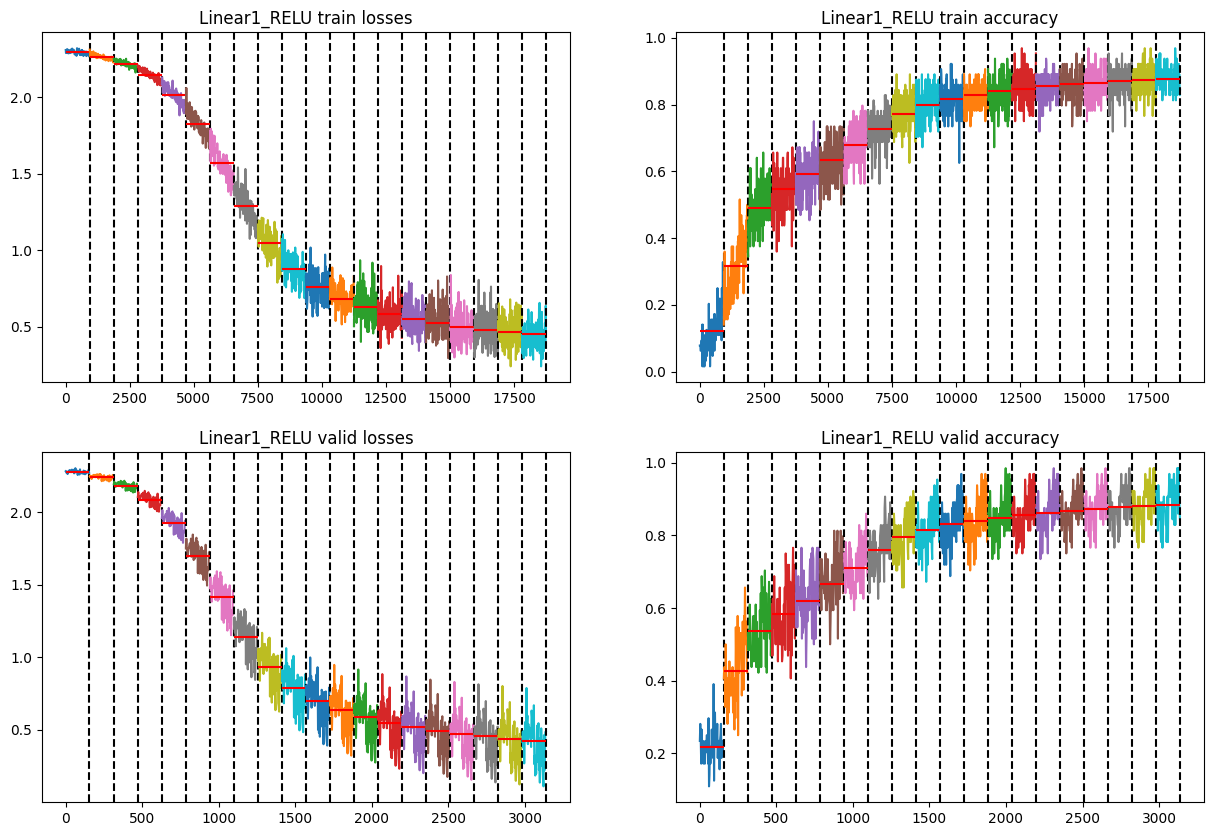

In [60]:
lin4 = test_architecture(Linear1RELU(), optim.SGD, nn.CrossEntropyLoss(), num_epochs=20,
                         model_title="Linear1_RELU")

**ВЫВОД**: модель сходится, ожидаемо, медленне, но ее показатели за 20 эпох пока не начали колебаться или ухудшаться. Потенциально она может дать лучшую точность, чем модель без скрутого слоя (что логично), но надо дольше ждать

#### Linear + RELU (1 hidden layer) + Adam + CrossEntropyLoss

Epoch 0 train: 100%|██████████| 938/938 [00:08<00:00, 104.52it/s, loss=0.239]


Train Accuracy: 0.9073172358591248


Epoch 0 valid: 100%|██████████| 157/157 [00:00<00:00, 166.19it/s, loss=0.269]


Valid Accuracy: 0.9466145833333334


Epoch 1 train: 100%|██████████| 938/938 [00:10<00:00, 91.74it/s, loss=0.171] 


Train Accuracy: 0.9612960245464247


Epoch 1 valid: 100%|██████████| 157/157 [00:00<00:00, 170.30it/s, loss=0.154]


Valid Accuracy: 0.9688501602564102


Epoch 2 train: 100%|██████████| 938/938 [00:10<00:00, 88.98it/s, loss=0.091] 


Train Accuracy: 0.9736192636072573


Epoch 2 valid: 100%|██████████| 157/157 [00:01<00:00, 146.78it/s, loss=0.108]


Valid Accuracy: 0.9722556089743589


Epoch 3 train: 100%|██████████| 938/938 [00:09<00:00, 95.96it/s, loss=0.145] 


Train Accuracy: 0.9804228922091782


Epoch 3 valid: 100%|██████████| 157/157 [00:01<00:00, 154.48it/s, loss=0.094]


Valid Accuracy: 0.9738581730769231


Epoch 4 train: 100%|██████████| 938/938 [00:10<00:00, 89.62it/s, loss=0.055] 


Train Accuracy: 0.9851754268943437


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 166.67it/s, loss=0.034]


Valid Accuracy: 0.9764623397435898


Epoch 5 train: 100%|██████████| 938/938 [00:10<00:00, 88.86it/s, loss=0.017] 


Train Accuracy: 0.9880269477054429


Epoch 5 valid: 100%|██████████| 157/157 [00:00<00:00, 158.57it/s, loss=0.031]


Valid Accuracy: 0.9776642628205128


Epoch 6 train: 100%|██████████| 938/938 [00:10<00:00, 88.28it/s, loss=0.02] 


Train Accuracy: 0.9906283351120597


Epoch 6 valid: 100%|██████████| 157/157 [00:00<00:00, 167.80it/s, loss=0.026]


Valid Accuracy: 0.9777644230769231


Epoch 7 train: 100%|██████████| 938/938 [00:10<00:00, 87.29it/s, loss=0.061]


Train Accuracy: 0.9925960512273212


Epoch 7 valid: 100%|██████████| 157/157 [00:01<00:00, 154.54it/s, loss=0.063]


Valid Accuracy: 0.9780649038461539


Epoch 8 train: 100%|██████████| 938/938 [00:10<00:00, 89.65it/s, loss=0.039]


Train Accuracy: 0.9934631803628602


Epoch 8 valid: 100%|██████████| 157/157 [00:00<00:00, 165.69it/s, loss=0.025]


Valid Accuracy: 0.9755608974358975


Epoch 9 train: 100%|██████████| 938/938 [00:10<00:00, 89.58it/s, loss=0.011]


Train Accuracy: 0.9944303628601922


Epoch 9 valid: 100%|██████████| 157/157 [00:01<00:00, 155.57it/s, loss=0.066]


Valid Accuracy: 0.9791666666666666


Epoch 10 train: 100%|██████████| 938/938 [00:10<00:00, 90.47it/s, loss=0.001] 


Train Accuracy: 0.9949806563500534


Epoch 10 valid: 100%|██████████| 157/157 [00:01<00:00, 151.82it/s, loss=0.113]


Valid Accuracy: 0.9779647435897436


Epoch 11 train: 100%|██████████| 938/938 [00:10<00:00, 89.54it/s, loss=0.001] 


Train Accuracy: 0.9954475720384205


Epoch 11 valid: 100%|██████████| 157/157 [00:01<00:00, 145.96it/s, loss=0.072]


Valid Accuracy: 0.9781650641025641


Epoch 12 train: 100%|██████████| 938/938 [00:10<00:00, 91.98it/s, loss=0]     


Train Accuracy: 0.9961479455709712


Epoch 12 valid: 100%|██████████| 157/157 [00:00<00:00, 160.16it/s, loss=0.054]


Valid Accuracy: 0.9744591346153846


Epoch 13 train: 100%|██████████| 938/938 [00:10<00:00, 87.58it/s, loss=0.065]


Train Accuracy: 0.9961979722518677


Epoch 13 valid: 100%|██████████| 157/157 [00:01<00:00, 153.92it/s, loss=0.015]


Valid Accuracy: 0.9775641025641025


Epoch 14 train: 100%|██████████| 938/938 [00:10<00:00, 90.37it/s, loss=0.014]


Train Accuracy: 0.9965815101387406


Epoch 14 valid: 100%|██████████| 157/157 [00:01<00:00, 151.08it/s, loss=0.01] 


Valid Accuracy: 0.9724559294871795


Epoch 15 train: 100%|██████████| 938/938 [00:10<00:00, 87.71it/s, loss=0.002]


Train Accuracy: 0.9965148078975453


Epoch 15 valid: 100%|██████████| 157/157 [00:00<00:00, 158.03it/s, loss=0.031]


Valid Accuracy: 0.9797676282051282


Epoch 16 train: 100%|██████████| 938/938 [00:10<00:00, 88.49it/s, loss=0.001]


Train Accuracy: 0.997315234791889


Epoch 16 valid: 100%|██████████| 157/157 [00:01<00:00, 150.14it/s, loss=0.064]


Valid Accuracy: 0.9800681089743589


Epoch 17 train: 100%|██████████| 938/938 [00:10<00:00, 89.66it/s, loss=0.001] 


Train Accuracy: 0.9978822038420491


Epoch 17 valid: 100%|██████████| 157/157 [00:01<00:00, 138.97it/s, loss=0.049]


Valid Accuracy: 0.9766626602564102


Epoch 18 train: 100%|██████████| 938/938 [00:10<00:00, 85.99it/s, loss=0]    


Train Accuracy: 0.9975653681963714


Epoch 18 valid: 100%|██████████| 157/157 [00:01<00:00, 143.58it/s, loss=0.091]


Valid Accuracy: 0.9744591346153846


Epoch 19 train: 100%|██████████| 938/938 [00:10<00:00, 88.70it/s, loss=0.001] 


Train Accuracy: 0.9967816168623266


Epoch 19 valid: 100%|██████████| 157/157 [00:01<00:00, 153.59it/s, loss=0.074]


Valid Accuracy: 0.9772636217948718


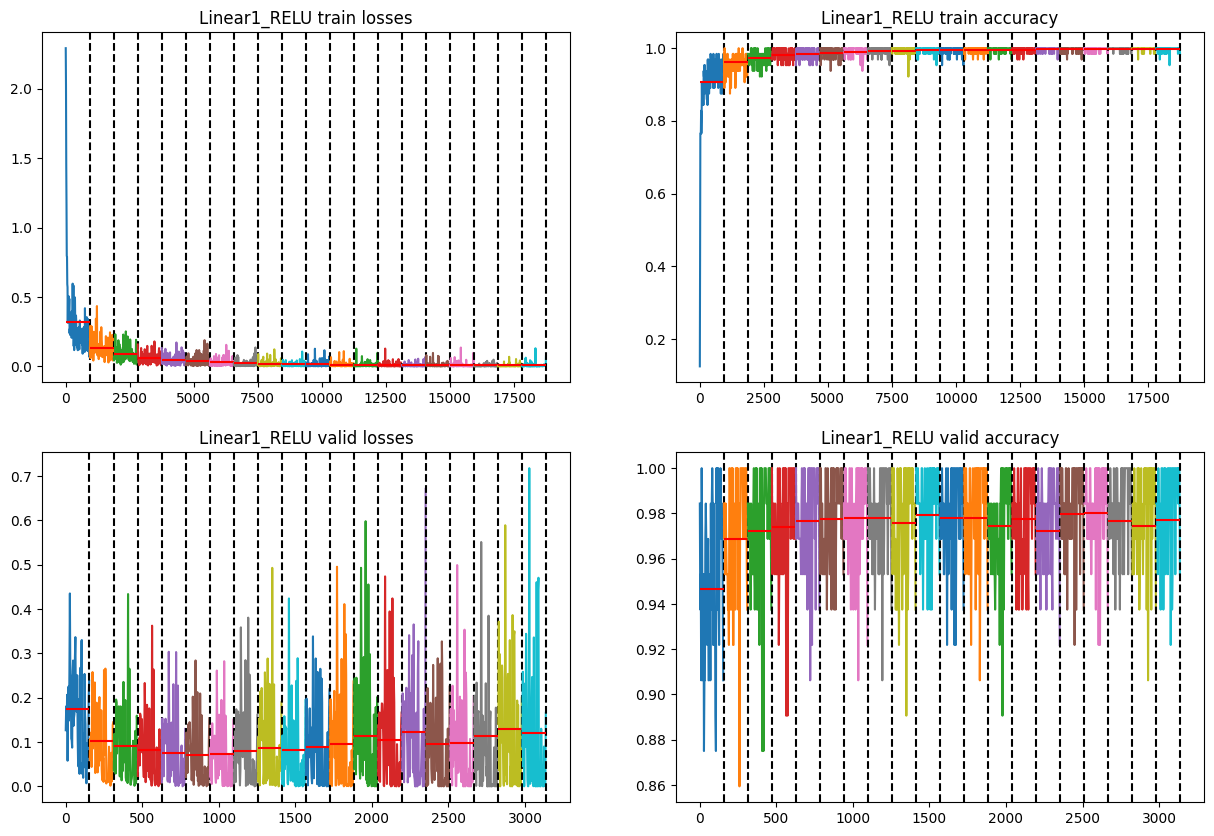

In [64]:
lin5 = test_architecture(Linear1RELU(), optim.Adam, nn.CrossEntropyLoss(), num_epochs=20,
                         model_title="Linear1_RELU")

**ВЫВОД**: модель быстро вышла на выскую точность, но, как можно заметить, она переобучилась, так как ошибка возрастает на тестовых данных к последним эпохам

#### Linear + Sigmoid (1 hidden) + Adam + CrossEntropy

In [70]:
class Linear1Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28 * 28, 200)
        self.linear2 = nn.Linear(200, 50)
        self.linear3 = nn.Linear(50, 10)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.sigmoid(self.linear1(x))
        x = self.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x


Epoch 0 train: 100%|██████████| 938/938 [00:09<00:00, 104.21it/s, loss=0.178]


Train Accuracy: 0.9052994930629669


Epoch 0 valid: 100%|██████████| 157/157 [00:00<00:00, 159.74it/s, loss=0.33] 


Valid Accuracy: 0.9483173076923077


Epoch 1 train: 100%|██████████| 938/938 [00:10<00:00, 91.03it/s, loss=0.181] 


Train Accuracy: 0.9624132870864461


Epoch 1 valid: 100%|██████████| 157/157 [00:01<00:00, 151.01it/s, loss=0.142]


Valid Accuracy: 0.9688501602564102


Epoch 2 train: 100%|██████████| 938/938 [00:17<00:00, 53.87it/s, loss=0.037]


Train Accuracy: 0.9731856990394877


Epoch 2 valid: 100%|██████████| 157/157 [00:12<00:00, 12.37it/s, loss=0.15] 


Valid Accuracy: 0.9702524038461539


Epoch 3 train: 100%|██████████| 938/938 [00:52<00:00, 18.00it/s, loss=0.205]


Train Accuracy: 0.9797391942369263


Epoch 3 valid: 100%|██████████| 157/157 [00:06<00:00, 23.34it/s, loss=0.12] 


Valid Accuracy: 0.9752604166666666


Epoch 4 train: 100%|██████████| 938/938 [00:09<00:00, 93.95it/s, loss=0.061] 


Train Accuracy: 0.9846251334044824


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 157.01it/s, loss=0.07] 


Valid Accuracy: 0.9772636217948718


Epoch 5 train: 100%|██████████| 938/938 [00:10<00:00, 90.02it/s, loss=0.006]


Train Accuracy: 0.9877601387406617


Epoch 5 valid: 100%|██████████| 157/157 [00:01<00:00, 156.95it/s, loss=0.034]


Valid Accuracy: 0.9766626602564102


Epoch 6 train: 100%|██████████| 938/938 [00:22<00:00, 41.22it/s, loss=0.049]


Train Accuracy: 0.9899446371398078


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 100.21it/s, loss=0.09] 


Valid Accuracy: 0.9763621794871795


Epoch 7 train: 100%|██████████| 938/938 [00:29<00:00, 32.31it/s, loss=0.014]


Train Accuracy: 0.9921458110992529


Epoch 7 valid: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s, loss=0.024]


Valid Accuracy: 0.9765625


Epoch 8 train: 100%|██████████| 938/938 [00:51<00:00, 18.37it/s, loss=0.02] 


Train Accuracy: 0.9934965314834578


Epoch 8 valid: 100%|██████████| 157/157 [00:00<00:00, 161.62it/s, loss=0.055]


Valid Accuracy: 0.9790665064102564


Epoch 9 train: 100%|██████████| 938/938 [00:10<00:00, 87.12it/s, loss=0.002]


Train Accuracy: 0.9942802828175027


Epoch 9 valid: 100%|██████████| 157/157 [00:00<00:00, 160.20it/s, loss=0.065]


Valid Accuracy: 0.9781650641025641


Epoch 10 train: 100%|██████████| 938/938 [00:10<00:00, 87.83it/s, loss=0.014] 


Train Accuracy: 0.9952474653148345


Epoch 10 valid: 100%|██████████| 157/157 [00:01<00:00, 144.06it/s, loss=0.077]


Valid Accuracy: 0.9753605769230769


Epoch 11 train: 100%|██████████| 938/938 [00:16<00:00, 57.50it/s, loss=0.001] 


Train Accuracy: 0.9957477321237994


Epoch 11 valid: 100%|██████████| 157/157 [00:00<00:00, 162.38it/s, loss=0.075]


Valid Accuracy: 0.9777644230769231


Epoch 12 train: 100%|██████████| 938/938 [00:10<00:00, 87.32it/s, loss=0.005]


Train Accuracy: 0.9962479989327642


Epoch 12 valid: 100%|██████████| 157/157 [00:00<00:00, 159.90it/s, loss=0.068]


Valid Accuracy: 0.9797676282051282


Epoch 13 train: 100%|██████████| 938/938 [00:10<00:00, 86.50it/s, loss=0.002]


Train Accuracy: 0.9963814034151548


Epoch 13 valid: 100%|██████████| 157/157 [00:00<00:00, 157.91it/s, loss=0.017]


Valid Accuracy: 0.9806690705128205


Epoch 14 train: 100%|██████████| 938/938 [00:10<00:00, 86.72it/s, loss=0.039]


Train Accuracy: 0.9960312166488794


Epoch 14 valid: 100%|██████████| 157/157 [00:00<00:00, 158.85it/s, loss=0.039]


Valid Accuracy: 0.9786658653846154


Epoch 15 train: 100%|██████████| 938/938 [00:11<00:00, 83.41it/s, loss=0.002]


Train Accuracy: 0.9978155016008537


Epoch 15 valid: 100%|██████████| 157/157 [00:01<00:00, 150.72it/s, loss=0.019]


Valid Accuracy: 0.9778645833333334


Epoch 16 train: 100%|██████████| 938/938 [00:10<00:00, 88.70it/s, loss=0.001] 


Train Accuracy: 0.9971651547491995


Epoch 16 valid: 100%|██████████| 157/157 [00:01<00:00, 148.55it/s, loss=0.003]


Valid Accuracy: 0.9774639423076923


Epoch 17 train: 100%|██████████| 938/938 [00:10<00:00, 86.84it/s, loss=0.013]


Train Accuracy: 0.9967816168623266


Epoch 17 valid: 100%|██████████| 157/157 [00:00<00:00, 163.33it/s, loss=0.075]


Valid Accuracy: 0.9799679487179487


Epoch 18 train: 100%|██████████| 938/938 [00:10<00:00, 85.63it/s, loss=0]    


Train Accuracy: 0.9980322838847385


Epoch 18 valid: 100%|██████████| 157/157 [00:00<00:00, 157.07it/s, loss=0.011]


Valid Accuracy: 0.9793669871794872


Epoch 19 train: 100%|██████████| 938/938 [00:10<00:00, 85.74it/s, loss=0]    


Train Accuracy: 0.9965815101387406


Epoch 19 valid: 100%|██████████| 157/157 [00:01<00:00, 140.09it/s, loss=0.077]


Valid Accuracy: 0.9793669871794872


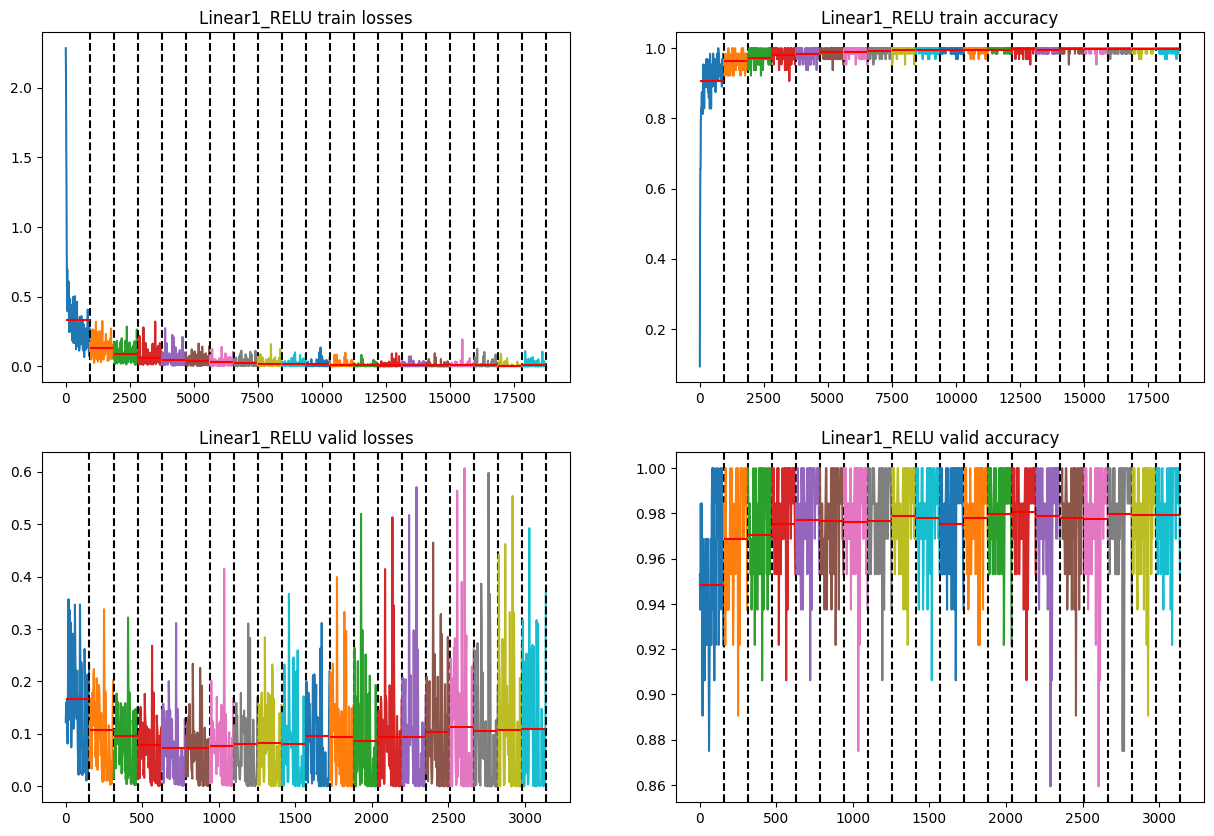

In [65]:
lin6 = test_architecture(Linear1RELU(), optim.Adam, nn.CrossEntropyLoss(), num_epochs=20,
                         model_title="Linear1_Sigmoid")

**ВЫВОД**: почти не отличается от предыдущего, модель тоже переобучилась

#### Linear + RELU + Softmax (3 hidden) + Dropout + BatchNorm + Adam + CrossEntropy

In [82]:
class Linear3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28 * 28, 300)
        self.linear2 = nn.Linear(300, 100)
        self.linear3 = nn.Linear(100, 50)
        self.linear4 = nn.Linear(50, 20)
        self.linear5 = nn.Linear(20, 10)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)
        self.drop3 = nn.Dropout(p=0.75)
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.batchnorm2 = nn.BatchNorm1d(50)
        self.batchnorm3 = nn.BatchNorm1d(20)
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.batchnorm1(x))
        x = self.linear3(self.drop1(x))
        x = self.relu(self.batchnorm2(x))
        x = self.linear4(self.drop2(x))
        x = self.relu(self.batchnorm3(x))
        x = self.linear5(self.drop3(x))
        return nn.Softmax(dim=1)(x)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0 train: 100%|██████████| 938/938 [00:11<00:00, 80.94it/s, loss=1.99]


Train Accuracy: 0.36971384738527213


Epoch 0 valid: 100%|██████████| 157/157 [00:01<00:00, 133.96it/s, loss=1.78]


Valid Accuracy: 0.7870592948717948


Epoch 1 train: 100%|██████████| 938/938 [00:13<00:00, 71.61it/s, loss=1.96]


Train Accuracy: 0.5090548292422625


Epoch 1 valid: 100%|██████████| 157/157 [00:01<00:00, 141.56it/s, loss=1.64]


Valid Accuracy: 0.8671875


Epoch 2 train: 100%|██████████| 938/938 [00:13<00:00, 68.51it/s, loss=1.86]


Train Accuracy: 0.5834111526147279


Epoch 2 valid: 100%|██████████| 157/157 [00:01<00:00, 143.37it/s, loss=1.59]


Valid Accuracy: 0.8720953525641025


Epoch 3 train: 100%|██████████| 938/938 [00:14<00:00, 66.34it/s, loss=1.83]


Train Accuracy: 0.625667022411953


Epoch 3 valid: 100%|██████████| 157/157 [00:01<00:00, 138.72it/s, loss=1.57]


Valid Accuracy: 0.9612379807692307


Epoch 4 train: 100%|██████████| 938/938 [00:14<00:00, 64.44it/s, loss=1.75]


Train Accuracy: 0.6537820170757738


Epoch 4 valid: 100%|██████████| 157/157 [00:01<00:00, 143.16it/s, loss=1.53]


Valid Accuracy: 0.9614383012820513


Epoch 5 train: 100%|██████████| 938/938 [00:13<00:00, 71.55it/s, loss=1.94]


Train Accuracy: 0.6719250266808965


Epoch 5 valid: 100%|██████████| 157/157 [00:01<00:00, 123.89it/s, loss=1.53]


Valid Accuracy: 0.9631410256410257


Epoch 6 train: 100%|██████████| 938/938 [00:15<00:00, 62.35it/s, loss=1.78]


Train Accuracy: 0.6836145944503735


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 135.15it/s, loss=1.51]


Valid Accuracy: 0.9634415064102564


Epoch 7 train: 100%|██████████| 938/938 [00:15<00:00, 61.35it/s, loss=1.8] 


Train Accuracy: 0.6908684631803629


Epoch 7 valid: 100%|██████████| 157/157 [00:01<00:00, 141.49it/s, loss=1.52]


Valid Accuracy: 0.9672475961538461


Epoch 8 train: 100%|██████████| 938/938 [00:14<00:00, 65.52it/s, loss=1.8] 


Train Accuracy: 0.7012740128068303


Epoch 8 valid: 100%|██████████| 157/157 [00:01<00:00, 147.94it/s, loss=1.5] 


Valid Accuracy: 0.9666466346153846


Epoch 9 train: 100%|██████████| 938/938 [00:15<00:00, 59.88it/s, loss=1.8] 


Train Accuracy: 0.701590848452508


Epoch 9 valid: 100%|██████████| 157/157 [00:01<00:00, 132.13it/s, loss=1.5] 


Valid Accuracy: 0.9688501602564102


Epoch 10 train: 100%|██████████| 938/938 [00:15<00:00, 60.68it/s, loss=1.64]


Train Accuracy: 0.7064100853788687


Epoch 10 valid: 100%|██████████| 157/157 [00:01<00:00, 129.11it/s, loss=1.5] 


Valid Accuracy: 0.9720552884615384


Epoch 11 train: 100%|██████████| 938/938 [00:15<00:00, 58.95it/s, loss=1.69]


Train Accuracy: 0.7089947972251868


Epoch 11 valid: 100%|██████████| 157/157 [00:01<00:00, 133.88it/s, loss=1.51]


Valid Accuracy: 0.9685496794871795


Epoch 12 train: 100%|██████████| 938/938 [00:15<00:00, 59.48it/s, loss=1.76]


Train Accuracy: 0.7130302828175027


Epoch 12 valid: 100%|██████████| 157/157 [00:01<00:00, 131.30it/s, loss=1.5] 


Valid Accuracy: 0.9724559294871795


Epoch 13 train: 100%|██████████| 938/938 [00:15<00:00, 58.97it/s, loss=1.78]


Train Accuracy: 0.7194503735325507


Epoch 13 valid: 100%|██████████| 157/157 [00:01<00:00, 125.89it/s, loss=1.5] 


Valid Accuracy: 0.9731570512820513


Epoch 14 train: 100%|██████████| 938/938 [00:15<00:00, 61.83it/s, loss=1.8] 


Train Accuracy: 0.7219683831376734


Epoch 14 valid: 100%|██████████| 157/157 [00:01<00:00, 144.02it/s, loss=1.52]


Valid Accuracy: 0.9697516025641025


Epoch 15 train: 100%|██████████| 938/938 [00:14<00:00, 65.33it/s, loss=1.81]


Train Accuracy: 0.72315234791889


Epoch 15 valid: 100%|██████████| 157/157 [00:01<00:00, 127.86it/s, loss=1.51]


Valid Accuracy: 0.9704527243589743


Epoch 16 train: 100%|██████████| 938/938 [00:32<00:00, 28.68it/s, loss=1.81]


Train Accuracy: 0.7221851654215582


Epoch 16 valid: 100%|██████████| 157/157 [00:03<00:00, 39.35it/s, loss=1.49]


Valid Accuracy: 0.9705528846153846


Epoch 17 train: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s, loss=1.74]


Train Accuracy: 0.7258537886872999


Epoch 17 valid: 100%|██████████| 157/157 [00:01<00:00, 133.52it/s, loss=1.5] 


Valid Accuracy: 0.9710536858974359


Epoch 18 train: 100%|██████████| 938/938 [00:16<00:00, 58.17it/s, loss=1.67]


Train Accuracy: 0.7265875133404482


Epoch 18 valid: 100%|██████████| 157/157 [00:01<00:00, 126.29it/s, loss=1.49]


Valid Accuracy: 0.9730568910256411


Epoch 19 train: 100%|██████████| 938/938 [00:15<00:00, 61.37it/s, loss=1.75]


Train Accuracy: 0.7265208110992529


Epoch 19 valid: 100%|██████████| 157/157 [00:01<00:00, 133.80it/s, loss=1.49]


Valid Accuracy: 0.9721554487179487


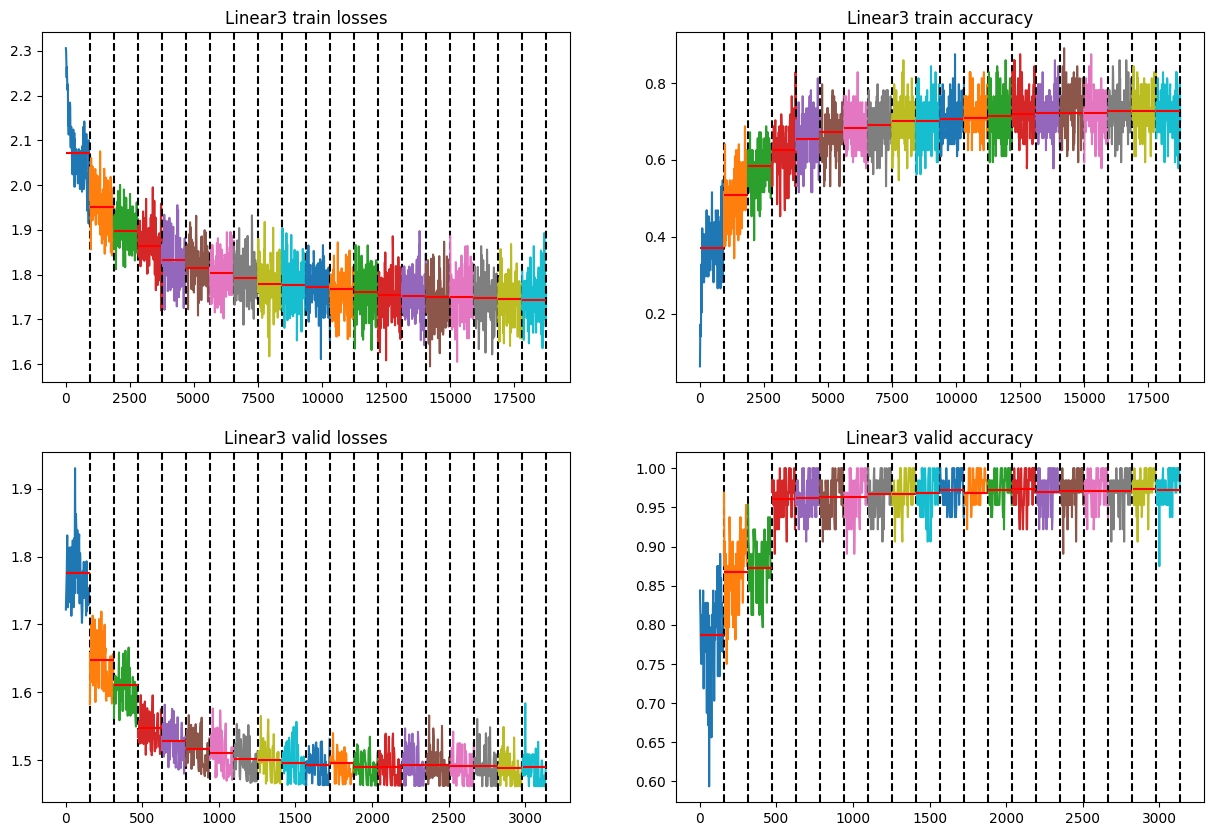

In [83]:
lin7 = test_architecture(Linear3(), optim.Adam, nn.CrossEntropyLoss(), num_epochs=20,
                         model_title="Linear3")

**ВЫВОД**: модель почему-то показывает высокую точность на тестовых данных, а на тренировочных - низкую

#### Linear + Dropout (1 layer hidden) + Adam

In [89]:
class Linear1Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28 * 28, 200)
        self.linear2 = nn.Linear(200, 50)
        self.linear3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x


Epoch 0 train:   0%|          | 0/938 [00:00<?, ?it/s, loss=2.26]

Epoch 0 train: 100%|██████████| 938/938 [00:09<00:00, 101.72it/s, loss=0.164]


Train Accuracy: 0.856590181430096


Epoch 0 valid: 100%|██████████| 157/157 [00:01<00:00, 146.70it/s, loss=0.286]


Valid Accuracy: 0.9485176282051282


Epoch 1 train: 100%|██████████| 938/938 [00:10<00:00, 88.46it/s, loss=0.183] 


Train Accuracy: 0.9406850320170758


Epoch 1 valid: 100%|██████████| 157/157 [00:01<00:00, 154.08it/s, loss=0.244]


Valid Accuracy: 0.9620392628205128


Epoch 2 train: 100%|██████████| 938/938 [00:11<00:00, 84.79it/s, loss=0.072]


Train Accuracy: 0.9583611259338314


Epoch 2 valid: 100%|██████████| 157/157 [00:01<00:00, 142.86it/s, loss=0.097]


Valid Accuracy: 0.9707532051282052


Epoch 3 train: 100%|██████████| 938/938 [00:11<00:00, 82.12it/s, loss=0.039]


Train Accuracy: 0.9667656083244397


Epoch 3 valid: 100%|██████████| 157/157 [00:00<00:00, 158.27it/s, loss=0.073]


Valid Accuracy: 0.9739583333333334


Epoch 4 train: 100%|██████████| 938/938 [00:11<00:00, 80.51it/s, loss=0.162]


Train Accuracy: 0.9718850053361793


Epoch 4 valid: 100%|██████████| 157/157 [00:00<00:00, 165.63it/s, loss=0.077]


Valid Accuracy: 0.9767628205128205


Epoch 5 train: 100%|██████████| 938/938 [00:11<00:00, 81.93it/s, loss=0.093]


Train Accuracy: 0.9762373265741728


Epoch 5 valid: 100%|██████████| 157/157 [00:00<00:00, 179.94it/s, loss=0.036]


Valid Accuracy: 0.9777644230769231


Epoch 6 train: 100%|██████████| 938/938 [00:11<00:00, 79.28it/s, loss=0.03] 


Train Accuracy: 0.9789887940234792


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 119.15it/s, loss=0.034]


Valid Accuracy: 0.9784655448717948


Epoch 7 train: 100%|██████████| 938/938 [00:11<00:00, 81.96it/s, loss=0.029] 


Train Accuracy: 0.9818903415154749


Epoch 7 valid: 100%|██████████| 157/157 [00:01<00:00, 151.59it/s, loss=0.061]


Valid Accuracy: 0.9782652243589743


Epoch 8 train: 100%|██████████| 938/938 [00:11<00:00, 82.18it/s, loss=0.103]


Train Accuracy: 0.9832077107790822


Epoch 8 valid: 100%|██████████| 157/157 [00:01<00:00, 150.92it/s, loss=0.048]


Valid Accuracy: 0.9793669871794872


Epoch 9 train: 100%|██████████| 938/938 [00:11<00:00, 84.81it/s, loss=0.051]


Train Accuracy: 0.9842415955176094


Epoch 9 valid: 100%|██████████| 157/157 [00:00<00:00, 157.00it/s, loss=0.114]


Valid Accuracy: 0.9783653846153846


Epoch 10 train: 100%|██████████| 938/938 [00:11<00:00, 84.66it/s, loss=0.032]


Train Accuracy: 0.9858591248665955


Epoch 10 valid: 100%|██████████| 157/157 [00:01<00:00, 149.47it/s, loss=0.023]


Valid Accuracy: 0.9789663461538461


Epoch 11 train: 100%|██████████| 938/938 [00:12<00:00, 74.55it/s, loss=0.028]


Train Accuracy: 0.987159818569904


Epoch 11 valid: 100%|██████████| 157/157 [00:01<00:00, 127.06it/s, loss=0.004]


Valid Accuracy: 0.9799679487179487


Epoch 12 train: 100%|██████████| 938/938 [00:12<00:00, 76.13it/s, loss=0.009]


Train Accuracy: 0.98877734791889


Epoch 12 valid: 100%|██████████| 157/157 [00:01<00:00, 125.54it/s, loss=0.005]


Valid Accuracy: 0.9791666666666666


Epoch 13 train: 100%|██████████| 938/938 [00:12<00:00, 74.15it/s, loss=0.049]


Train Accuracy: 0.9891108591248666


Epoch 13 valid: 100%|██████████| 157/157 [00:01<00:00, 155.98it/s, loss=0.015]


Valid Accuracy: 0.9794671474358975


Epoch 14 train: 100%|██████████| 938/938 [00:11<00:00, 83.87it/s, loss=0.014]


Train Accuracy: 0.9903114994663821


Epoch 14 valid: 100%|██████████| 157/157 [00:01<00:00, 150.86it/s, loss=0.051]


Valid Accuracy: 0.9785657051282052


Epoch 15 train: 100%|██████████| 938/938 [00:11<00:00, 84.13it/s, loss=0.018]


Train Accuracy: 0.9904615795090715


Epoch 15 valid: 100%|██████████| 157/157 [00:01<00:00, 143.91it/s, loss=0.011]


Valid Accuracy: 0.9794671474358975


Epoch 16 train: 100%|██████████| 938/938 [00:11<00:00, 82.98it/s, loss=0.009]


Train Accuracy: 0.9910618996798293


Epoch 16 valid: 100%|██████████| 157/157 [00:00<00:00, 159.16it/s, loss=0.036]


Valid Accuracy: 0.9790665064102564


Epoch 17 train: 100%|██████████| 938/938 [00:10<00:00, 87.53it/s, loss=0.022]


Train Accuracy: 0.9920791088580576


Epoch 17 valid: 100%|██████████| 157/157 [00:01<00:00, 153.20it/s, loss=0.051]


Valid Accuracy: 0.9790665064102564


Epoch 18 train: 100%|██████████| 938/938 [00:11<00:00, 83.50it/s, loss=0.002]


Train Accuracy: 0.9920791088580576


Epoch 18 valid: 100%|██████████| 157/157 [00:01<00:00, 145.36it/s, loss=0.066]


Valid Accuracy: 0.9781650641025641


Epoch 19 train: 100%|██████████| 938/938 [00:11<00:00, 84.62it/s, loss=0.049]


Train Accuracy: 0.9923959445037354


Epoch 19 valid: 100%|██████████| 157/157 [00:01<00:00, 144.68it/s, loss=0.035]


Valid Accuracy: 0.9802684294871795


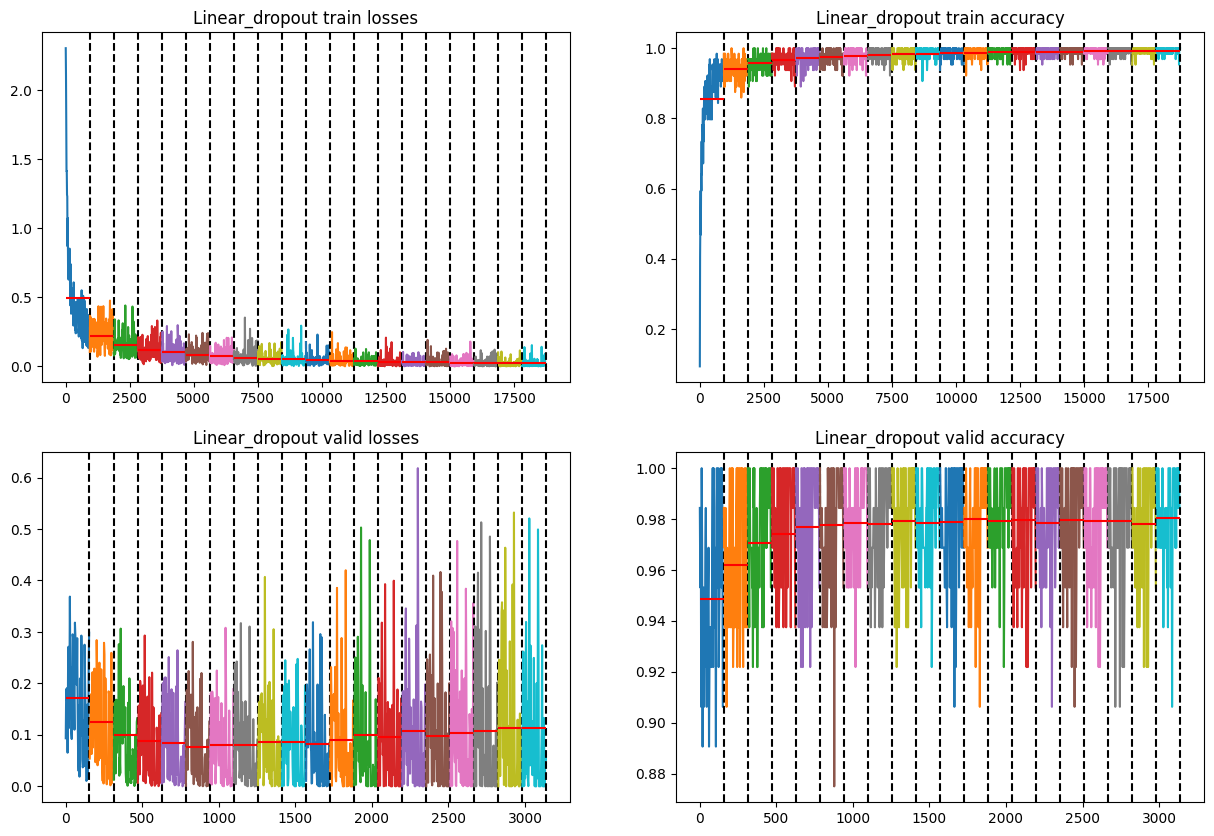

In [92]:
lin8 = test_architecture(Linear1Dropout(), optim.Adam, nn.CrossEntropyLoss(), num_epochs=20,
                         model_title="Linear_dropout")

**ВЫВОД**: даже примитивное применение dropout в линейной модели чуть-чуть уменьшило переобучение (но оно все равно есть)

### CNN модель

#### CNN + BatchNorm

In [86]:
import torch.nn.functional as F


class CNN_batchnorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=5,
                               stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.batchnorm1 = nn.BatchNorm2d(20)
        self.linear1 = nn.Linear(in_features=320, out_features=50)
        self.batchnorm2 = nn.BatchNorm1d(50)
        self.linear2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.batchnorm1(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.batchnorm2(self.linear1(x)))
        x = F.relu(self.linear2(x))
        return F.log_softmax(x, dim=1)

Epoch 0 train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0 train: 100%|██████████| 938/938 [00:22<00:00, 41.51it/s, loss=0.062]


Train Accuracy: 0.9631636872998933


Epoch 0 valid: 100%|██████████| 157/157 [00:01<00:00, 115.78it/s, loss=0.052]


Valid Accuracy: 0.9873798076923077


Epoch 1 train: 100%|██████████| 938/938 [00:21<00:00, 43.39it/s, loss=0.06] 


Train Accuracy: 0.987059765208111


Epoch 1 valid: 100%|██████████| 157/157 [00:01<00:00, 117.21it/s, loss=0.016]


Valid Accuracy: 0.9895833333333334


Epoch 2 train: 100%|██████████| 938/938 [00:22<00:00, 42.30it/s, loss=0.029]


Train Accuracy: 0.9907450640341515


Epoch 2 valid: 100%|██████████| 157/157 [00:01<00:00, 118.71it/s, loss=0.009]


Valid Accuracy: 0.9906850961538461


Epoch 3 train: 100%|██████████| 938/938 [00:29<00:00, 31.84it/s, loss=0.007]


Train Accuracy: 0.9922291889007471


Epoch 3 valid: 100%|██████████| 157/157 [00:01<00:00, 115.56it/s, loss=0.002]


Valid Accuracy: 0.9906850961538461


Epoch 4 train: 100%|██████████| 938/938 [00:21<00:00, 42.67it/s, loss=0.007]


Train Accuracy: 0.9931630202774814


Epoch 4 valid: 100%|██████████| 157/157 [00:01<00:00, 118.95it/s, loss=0.002]


Valid Accuracy: 0.991386217948718


Epoch 5 train: 100%|██████████| 938/938 [00:22<00:00, 42.55it/s, loss=0.002]


Train Accuracy: 0.9942302561366062


Epoch 5 valid: 100%|██████████| 157/157 [00:01<00:00, 116.61it/s, loss=0.001]


Valid Accuracy: 0.9916866987179487


Epoch 6 train: 100%|██████████| 938/938 [00:22<00:00, 42.25it/s, loss=0.092]


Train Accuracy: 0.9949806563500534


Epoch 6 valid: 100%|██████████| 157/157 [00:01<00:00, 127.14it/s, loss=0.002]


Valid Accuracy: 0.9891826923076923


Epoch 7 train: 100%|██████████| 938/938 [00:21<00:00, 42.89it/s, loss=0.013]


Train Accuracy: 0.9956810298826041


Epoch 7 valid: 100%|██████████| 157/157 [00:01<00:00, 121.23it/s, loss=0.013]


Valid Accuracy: 0.9912860576923077


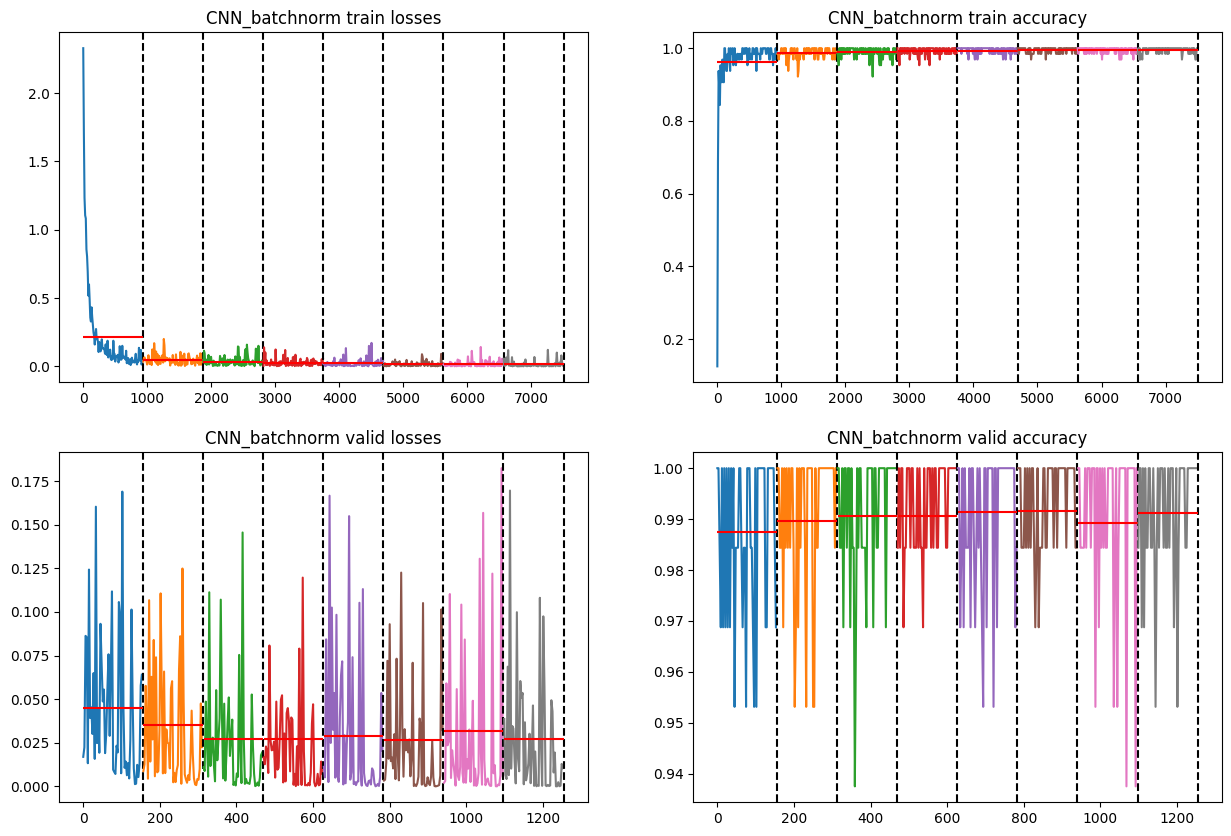

In [88]:
cnn1 = test_architecture(CNN_batchnorm(), optim.Adam, nn.CrossEntropyLoss(), num_epochs=8,
                         model_title="CNN_batchnorm")

**ВЫВОД**: сверточная нейросеть показала себя лучше всего, что неудивительно. Модель быстро обучилась и показывает высокую точность. В последних двух эпохах произошел провал, возможно, дальше результаты будут ухудшаться, несмотря на то, что я применил один из методов для борьбы с переобучением  

## ИТОГИ

In [93]:
import pandas as pd
data = [lin1, lin2, lin3, lin4, lin5, lin6, lin7, lin8, cnn1]
df = pd.DataFrame(data, columns=["Model Name", "Optimizer", "Loss func", "Min Error", "Accuracy", "Precision", "Recall", "F-score"])

In [97]:
df

,Model Name,Optimizer,Loss func,Min Error,Accuracy,Precision,Recall,F-score
0,Linear,SGD,CrossEntropyLoss,9.014458e-02,0.887220,0.886036,0.885483,0.885288
1,Linear,Adam,CrossEntropyLoss,9.731399e-03,0.926382,0.925392,0.925301,0.925217
2,Linear,AdamW,CrossEntropyLoss,1.388490e-02,0.928385,0.927618,0.927475,0.927448
3,Linear1_RELU,Adam,CrossEntropyLoss,1.303851e-08,0.979267,0.979350,0.979007,0.979116
4,Linear1_RELU,Adam,CrossEntropyLoss,2.048909e-08,0.977264,0.977049,0.977033,0.976999
5,Linear1_Sigmoid,Adam,CrossEntropyLoss,2.421438e-08,0.979367,0.979612,0.979075,0.979288
6,Linear3,Adam,CrossEntropyLoss,1.461610e+00,0.972155,0.972097,0.972061,0.971944
7,Linear_dropout,Adam,CrossEntropyLoss,1.303851e-08,0.980268,0.980238,0.980119,0.980144
8,CNN_batchnorm,Adam,CrossEntropyLoss,4.395332e-05,0.991286,0.991163,0.991264,0.991207


Как можно заметить, модели без скрытых слоев показывают результаты хуже, чем остальные. Добавление всего одного скрытого слоя уменьшает ошибку на 5 порядков и повышает accuracy. Между использованными оптимизаторами большой разницы нет, за исключением времени. SGD работает значительно медленне (точность повышается медленно), но он, в отличие от Adam, за рассматриваемые эпохи не переобучился. По найденной мной информации в какой-то статье, SGD лучше находит закономерности, но платит за это более длительной тренировкой, а Adam рабоатет чуть хуже, но быстрее. Это и подтвердилось. Применение dropout на линейную модель с Adam помогло, во-первых, немного справиться с переобучением, а во-вторых, благодаря этому еще немного повысило точность (эта модель на 2 места находится). Ну и, понятное дело, лучший результат показала сверточная нейронная сеть с применением batchnorm (с dropout результат почти не отличается, отдельно рассматривать эту модель не стал) 